##Automatic sycn with google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd  /content/drive/MyDrive/tcc
!ls

Mounted at /content/drive
/content/drive/MyDrive/tcc
 copias_imagens		  embeddingsEuclidean.csv   keyframesTemp
 distances.csv		  frame_names.pdf	    SBR
 DrivingNewYorkCity.mp4   framesOSORIM		   'SBR (1)'
 embeddingsCosine.csv	  frames_stereo_centre	    setup.py.gdoc
 embeddings.csv		  keyframe_names.pdf	    tcc


# Imports

In [ ]:
from itertools import islice
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
import csv
from huggingface_hub import notebook_login
import torch

from PIL import Image
import requests

from transformers import AutoProcessor, BlipForConditionalGeneration

# pip install

In [ ]:
!pip install -q av
!pip install -q fpdf
!pip install -q ffmpeg
!pip install -q qwen_vl_utils
!pip install -q transformers
!pip install --upgrade -q accelerate bitsandbytes
!pip install decord
!pip install -q git+https://github.com/huggingface/transformers.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 27.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Functions

## def select_frame_time

In [ ]:
# Funcao tem por objetivo retornar uma fatia do DataFrame

# Start_frame indica o frame inicial dentro do DataFrame
# end_frame indica o frame final dentro do DataFrame
# Soh essas dois parametros retornam uma matriz do tempo x frame

# start_time indica o tempo inicial dentro do DataFrame
# end_time indica o tempo final dentro do DataFrame
def select_frame_time(distance_df, start_frame=0, end_frame=None, start_time=0, end_time=0):
  cosine_distances = []
  #Quantidade de frames analisados (melhorar) # Comentário original
  # Calcula o índice inicial para fatiar com base em start_frame e start_time
  st = start_frame + start_time
  et = end_frame + end_time
  # Itera sobre os valores únicos na coluna 'image1' do distance_df,
  # usando islice para selecionar um intervalo de frames
  for e,i in islice(enumerate(distance_df['image1'].unique()),start_frame,end_frame):
    # Filtra o DataFrame para linhas onde 'image1' é o valor único atual 'i'
    # Em seguida, seleciona linhas usando iloc com base no intervalo de tempo calculado (st-e a et-e),
    # garantindo que o índice inicial não seja negativo com max(0, ...)
    cosine_distances.append(distance_df[distance_df['image1'] == i].iloc[max(0,st-e):et-e])

  # Concatena todos os DataFrames selecionados na lista e retorna o resultado
  return pd.concat(cosine_distances)

## def run_inteference

In [ ]:
import torch
from qwen_vl_utils import process_vision_info

def run_inference(processor, model, messages):
    text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text_prompt],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    )
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    inputs = inputs.to(device)

    output_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )

    return output_text

# Load Frames

In [ ]:
import os

def extract_mutiple_videos(directory_path, output_base_path):
    """
    Extracts frames from all MP4 videos in a directory.

    Args:
        directory_path (str): The path to the directory containing the video files.
        output_base_path (str): The base path where output directories for frames will be created.
    """
    for filename in os.listdir(directory_path):
        if filename.endswith(".mp4"):
            video_path = os.path.join(directory_path, filename)

            # Get the video filename without the extension
            video_name_without_extension, _ = os.path.splitext(filename)

            # Create the full path for the new directory by adding "frames"
            video_output_directory = os.path.join(output_base_path, video_name_without_extension + "_frames")

            # Create the directory, including any necessary parent directories
            os.makedirs(video_output_directory, exist_ok=True)

            # Call the extract_frames function for the current video
            # Note: The extract_frames function is assumed to be defined elsewhere
            extract_frames(video_path, video_output_directory)

directory_path = "/content/drive/MyDrive/SBR/OxfordCarAutomatGIT-dataSetGIthub"
output_base_path = "/content/drive/MyDrive/SBR/OxfordCarAutomatGIT-dataSetGIthub/Frames"

extract_mutiple_videos(directory_path, output_base_path)

Starting video frame extraction...
Ensured output base directory exists: /content/drive/MyDrive/SBR/OxfordCarAutomatGIT-dataSetGIthub/FrameForClip
Frame extraction process finished.


In [ ]:
# prompt: get frame by frame of a video

import cv2
import os

! ls "/content/drive/My Drive/tcc/"

video_path = "/content/drive/MyDrive/tcc/DrivingNewYorkCity.mp4"
output_path = "/content/drive/My Drive/tcc/framesNY/"


def extract_frames(video_path, output_path):
    # Create the output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if video.isOpened() == False:
        print("Error opening video file")
        return

    frame_count = 0
    while video.isOpened():
        frame_count += 1
        # Read a frame from the video
        success, frame = video.read()

        # Break the loop if no frame is read
        if not success:
            break

        #save 30fps
        if(not frame_count%10):
          # Save the frame as an image
          frame_path = os.path.join(output_path, f"frame_{frame_count:06d}.jpg")
          cv2.imwrite(frame_path, frame)

    # Release the video object
    video.release()

    print(f"Extracted {frame_count} frames to {output_path}")

#extract_frames(video_path, output_path)

 copias_imagens				   framesOSORIM
 distances.csv				   frames_stereo_centre
 DrivingNewYorkCity.mp4			   keyframe_names.pdf
 embeddingsCosine.csv			   keyframesTemp
 embeddings.csv				   SBR
 embeddingsEuclidean.csv		  'SBR (1)'
'filmagemOsorim 2024-11-26 16-43-57.mp4'   setup.py.gdoc
 frame_names.pdf			   tcc


# Blip

In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
#image = Image.open("/content/drive/My Drive/tcc/framesOSORIM/frame_006000.jpg")
text = "the image is"

inputs = processor(images=image, text=text, return_tensors="pt", padding=True)
outputs = model(**inputs)

In [ ]:
print(outputs.image_embeds.shape)
len(outputs.image_embeds[0][0].detach().numpy().flatten().tolist())

torch.Size([1, 577, 768])


768

# Video description

In [ ]:
text = "Describe the image"
inputs = processor(images=image, text=text, return_tensors="pt")
outputs = model.generate(**inputs)
print(processor.decode(outputs[0], skip_special_tokens=True))

NameError: name 'processor' is not defined

# Create CSV file for embeedings(need improviment)

## Joao

Se der erro no multimodaldata quando for carregar o 'processor' quando for carregar

In [ ]:
import transformers
print(transformers.__version__)

In [ ]:
!pip uninstall -q -y transformers
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install --upgrade -q accelerate bitsandbytes
!pip install -q git+https://github.com/huggingface/transformers.git
# Depois de executar esta célula, vá em "Ambiente de execução" -> "Reiniciar ambiente de execução" no menu do Colab.

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)


model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, quantization_config=quantization_config, device_map="auto")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
import os

def extract_frames_folder(image_folder):
  images = [filename for filename in os.listdir(image_folder) if filename.endswith((".jpg", ".jpeg", ".png"))]
  images.sort()
  return images

In [ ]:
output_csv_path = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Embeddings/Embeddings_LLaVa/"
file_csv = "2014-06-25-16-45-34_stereo_centre_02.csv"
os.makedirs(output_csv_path, exist_ok=True)
output_csv_path = output_csv_path + file_csv

image_folder = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Frames/2014-06-25-16-45-34_stereo_centre_02_frames/"
images = extract_frames_folder(image_folder)
print(images[0])

image_path = os.path.join(image_folder, images[0])
image = Image.open(image_path)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

inputs = processor(text=["<image>\nWhat’s shown in this image?"], images=image, return_tensors="pt", padding=True).to(device)
outputs = model(**inputs)

frame_000010.jpg


In [ ]:
%%time
#image_embeddings = outputs.image_hidden_states.detach().cpu().numpy().flatten().tolist()  # Move para CPU antes de converter para numpy

# Faz a inferência e obtém os embeddings da imagem
#image_embeddings = outputs.image_embeds.detach().numpy().flatten().tolist()  # Obtém os embeddings das imagens (convertendo para numpy)
print(outputs.image_hidden_states.shape)
#print(outputs.image_hidden_states.detach().cpu().numpy().flatten().tolist())
len(outputs.image_hidden_states.detach().cpu().numpy().flatten().tolist())

AttributeError: 'BlipForConditionalGenerationModelOutput' object has no attribute 'image_hidden_states'

In [ ]:
image_embeddings1d = outputs.image_hidden_states[0]
print("\n1d")
print(image_embeddings1d)
print(image_embeddings1d.detach().cpu().numpy().tolist())
len(image_embeddings1d.detach().cpu().numpy().tolist())


1d
tensor([-0.0957,  0.6670, -0.8540,  ..., -0.2314,  0.4834, -0.3376],
       device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)
[-0.095703125, 0.6669921875, -0.85400390625, -0.301513671875, -0.434814453125, -0.026641845703125, 0.4482421875, 0.6005859375, -0.509765625, -0.88818359375, -0.257080078125, 0.578125, -0.0148162841796875, -0.2191162109375, -0.16943359375, -0.260498046875, -0.08892822265625, 0.35791015625, -0.14990234375, 0.2298583984375, -0.2802734375, -0.060028076171875, 0.480712890625, -0.123291015625, 0.19091796875, -0.1356201171875, -0.5224609375, 0.203369140625, 0.00911712646484375, -0.466552734375, -0.47119140625, -0.11297607421875, 0.6962890625, 0.62744140625, -0.1807861328125, 0.2069091796875, 0.1168212890625, -0.73583984375, -0.39306640625, -0.0141754150390625, 0.11334228515625, -0.0838623046875, -0.359130859375, -0.155517578125, 0.13330078125, 0.49267578125, -0.2052001953125, -0.07391357421875, -0.5205078125, 0.304931640625, -0.1724853515625, -0.1607

4096

In [ ]:
def save_embedding_csv_llava(output_path, filename, image_folder_path):
  os.makedirs(output_path, exist_ok=True)
  output_csv_path = output_path + filename

  images = extract_frames_folder(image_folder_path)
  print(images[0])

  header = ['image_name'] + [f'embedding_{i}' for i in range(576)]  # Tamanho do embedding de 576 (lava)

  # Abrindo o arquivo CSV em modo append (para adicionar dados no arquivo)
  with open(output_csv_path, mode='w', newline='') as file:
      writer  = csv.writer(file)
      writer.writerow(header)  # Escreve o cabeçalho

      for filename in images:
          image_path = os.path.join(image_folder, filename)
          image = Image.open(image_path)

          device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

          inputs = processor(text=["<image>\nWhat’s shown in this image?"], images=image, return_tensors="pt", padding=True).to(device)
          outputs = model(**inputs)
          image_embeddings = outputs.image_hidden_states.detach().cpu().numpy().tolist()  # Move para CPU antes de converter para numpy

          # Adiciona o nome da imagem e os embeddings à lista para escrever no CSV
          writer.writerow([filename] + image_embeddings) # Escreve a linha no CSV

  print("Done")

In [ ]:
output_path = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Embeddings/Embeddings_LLaVa/"
filename = "2014-06-25-16-45-34_stereo_centre_02.csv"
image_folder = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Frames/2014-06-25-16-45-34_stereo_centre_02_frames/"

save_embedding_csv_llava(output_path, filename, image_folder)

frame_000010.jpg
Done


#PATH PRINCIPAL /content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/

In [ ]:
# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Add a small delay to allow mounting to stabilize (optional, but can sometimes help)
import time
time.sleep(2) # Wait for 2 seconds

# Check the base MyDrive directory to see if it's accessible
print("Contents of /content/drive/MyDrive/:")
try:
    print(os.listdir('/content/drive/MyDrive'))
except Exception as e:
    print(f"Could not list contents of /content/drive/MyDrive/. Google Drive may not be properly mounted or accessible. Error: {e}")


# Base directory containing the image folders (assuming they end with '_frames')
frames_base_directory = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Frames/"
output_csv_directory = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Embeddings/"

# **Explicitly create the target directory before proceeding**
# This ensures the directory exists in the Colab environment
# exist_ok=True prevents an error if the directory is already there
print(f"Ensuring directory exists: {frames_base_directory}")
os.makedirs(frames_base_directory, exist_ok=True)
print("Directory creation/check complete.")


# Create the output directory for embeddings if it doesn't exist
os.makedirs(output_csv_directory, exist_ok=True)

# Now, check and list the frames directory again
if os.path.exists(frames_base_directory):
    print(f"Confirmation: The directory '{frames_base_directory}' exists in the Colab environment AFTER creation/check.")
    # Check if the directory is actually readable
    if os.access(frames_base_directory, os.R_OK):
        print(f"Confirmation: The directory '{frames_base_directory}' is readable.")
        # Now, attempt to list the directory contents
        try:
            # It's possible this directory is empty if frame extraction hasn't run yet
            # or failed. Listing it is still a good check for accessibility.
            directory_contents = os.listdir(frames_base_directory)
            print(f"Contents of '{frames_base_directory}': {directory_contents}")

            # Proceed with iterating only if there are items to process
            if directory_contents:
                # Iterate through all items in the frames base directory
                for item_name in directory_contents: # Iterate over the list we just got
                    item_path = os.path.join(frames_base_directory, item_name)

                    # Check if the item is a directory and ends with '_frames'
                    if os.path.isdir(item_path) and item_name.endswith("_frames"):
                        # Extract the base name for the CSV file
                        csv_name_base = item_name.replace("_frames", "")
                        output_csv_path = os.path.join(output_csv_directory, f"{csv_name_base}_embeddings.csv")

                        # Check if the corresponding CSV file already exists
                        if not os.path.exists(output_csv_path):
                            print(f"Processing folder: {item_name}")
                            # Call the clip_processor_function for the current image folder
                            # Ensure clip_processor_function is defined in a previous cell and accessible
                            try:
                                # Make sure clip_processor_function is defined in a previous cell and ran
                                clip_processor_function(item_path, output_csv_directory, csv_name_base)
                            except NameError:
                                print("Error: clip_processor_function is not defined. Please run the cell defining this function.")
                            except Exception as clip_e:
                                print(f"An error occurred during clip_processor_function for {item_name}: {clip_e}")

                        else:
                            print(f"Embeddings already generated for {item_name}. Skipping.")
            else:
                print(f"Directory '{frames_base_directory}' is empty. No image folders to process.")


            print("Finished attempting to process image folders.") # Changed wording slightly

        except Exception as e:
            print(f"An unexpected error occurred while listing or processing the directory: {e}")

    else:
        print(f"Error: The directory '{frames_base_directory}' exists but is not readable.")
        print("There might be a permissions issue with the mounted drive.")

else:
    # This case should ideally not happen after os.makedirs(exist_ok=True)
    print(f"Critical Error: The directory '{frames_base_directory}' still does NOT exist after attempting to create it.")
    print("This is highly unusual and indicates a severe issue with Google Drive mounting in Colab.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of /content/drive/MyDrive/:
['Classroom', 'chamado-de-cthulhu-ficha-de-personagem-biblioteca-elfica.pdf', 'chamado-de-cthulhu-cartoes-de-armas-biblioteca-elfica.pdf', 'charactersheeteso.pdf', 'impor', 'declaração edval.docx', 'aposentadoria', 'documentos sindicato 001.jpg', 'Governo título ', 'Documentos', 'metodologia de pesquisa', 'Atividades', 'Adobe Scan Jun 13, 2022.pdf', 'academico.pdf', 'estudo', 'Documento sem nome (1).gdoc', 'jamboeditora-os-sussurros-do-caos-rastejante_62c4241f32ebd.pdf', 'trabalho2.py', 'assembly.gdoc', 'trabalhocorrigido.py', 'assemblycomentario.txt', 'session_buddy_export_2022_08_22_18_51_54.txt', 'pessoal', 'atividade 1.gdoc', 'Captura de tela de 2022-11-16 10-17-26.png', 'Screenshot_2023-03-08-19-50-41-305_com.nu.production.jpg', 'Apresentação sem título (1).gslides', 'Inscrição no evento.gform', 'trabalho10.c'

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Processamento concluído! Embeddings salvos em: /content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Embeddings/2014-07-14-14-49-50_stereo_centre_01_embeddings.csv
Processing folder: 2015-02-03-19-43-11_stereo_centre_04_frames
Usando dispositivo: cuda
Processamento concluído! Embeddings salvos em: /content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Embeddings/2015-02-03-19-43-11_stereo_centre_04_embeddings.csv
Processing folder: 2014-11-21-16-07-03_stereo_centre_01_frames
Usando dispositivo: cuda
Processamento concluído! Embeddings salvos em: /content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Embeddings/2014-11-21-16-07-03_stereo_centre_01_embeddings.csv
Processing folder: 2015-02-13-09-16-26_stereo_centre_02_frames
Usando dispositivo: cuda
Processamento concluído! Embeddings salvos em: /content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Embeddings/2015-02-13-09-16-26_stereo_centre_02_embeddings.csv
Processing folder: 2014-12-09-13-21-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import time
time.sleep(2)

import os

# Define the base directory where video frames are stored and the directory for saving embeddings.
frames_base_directory = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Frames/"
output_csv_directory = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Embeddings/"

# Create the directories if they don't already exist.
# exist_ok=True prevents errors if the directories are already present.
os.makedirs(frames_base_directory, exist_ok=True)
os.makedirs(output_csv_directory, exist_ok=True)

# Get a list of all files and directories within the frames base directory.
directory_contents = os.listdir(frames_base_directory)

# Loop through each item found in the frames base directory.
for item_name in directory_contents:
    # Construct the full path for the current item.
    item_path = os.path.join(frames_base_directory, item_name)

    # Check if the current item is a directory and if its name ends with "_frames".
    # This is how the code identifies folders containing video frames.
    if os.path.isdir(item_path) and item_name.endswith("_frames"):
        # Extract the base name for the CSV file by removing "_frames" from the directory name.
        csv_name_base = item_name.replace("_frames", "")
        # Construct the full path for the potential output CSV file for embeddings.
        output_csv_path = os.path.join(output_csv_directory, f"{csv_name_base}_embeddings.csv")

        # Check if a CSV file with the same base name already exists in the embeddings directory.
        if not os.path.exists(output_csv_path):
            # If the CSV file does NOT exist, call the function to process the images and generate embeddings.
            # The 'clip_processor_function' is assumed to be defined in a previous cell
            # and handles the actual embedding generation and saving to CSV.
            clip_processor_function(item_path, output_csv_directory, csv_name_base)
        # If the CSV file already exists, the code does nothing for this folder,
        # effectively skipping the embedding generation.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image
import os
import csv
import torch
import numpy as np
from transformers import CLIPProcessor, CLIPModel

def clip_processor_function(image_folder, output_csv_base_path, csv_filename_base):
    # Verifica e usa GPU se disponível
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Usando dispositivo: {device}")

    # Inicializa modelo e processador
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # Lista de imagens
    images = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Constrói o caminho completo para o arquivo CSV
    output_csv_path = os.path.join(output_csv_base_path, f"{csv_filename_base}_embeddings.csv")

    # Cria CSV
    header = ['image_name'] + [f'embedding_{i}' for i in range(512)]
    with open(output_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)

        for filename in images:
            try:
                image_path = os.path.join(image_folder, filename)
                image = Image.open(image_path)

                # Move inputs para o mesmo dispositivo que o modelo (GPU)
                inputs = processor(images=image, return_tensors="pt", padding=True).to(device)

                # Obtém embeddings
                with torch.no_grad():  # Desabilita gradientes para inferência mais rápida
                    outputs = model.get_image_features(**inputs)
                    image_embeddings = outputs.cpu().numpy().flatten().tolist()  # Move para CPU antes de converter para numpy

                writer.writerow([filename] + image_embeddings)

            except Exception as e:
                print(f"Erro ao processar {filename}: {str(e)}")
                continue

    print("Processamento concluído! Embeddings salvos em:", output_csv_path)


In [ ]:
import requests
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModel

model = AutoModel.from_pretrained("openai/clip-vit-base-patch32", torch_dtype=torch.bfloat16, attn_implementation="sdpa")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
labels = "a photo of a car in a urban area"

inputs = processor(text=labels, images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)
most_likely_idx = probs.argmax(dim=1).item()
most_likely_label = labels[most_likely_idx]
print(f"Most likely label: {most_likely_label} with probability: {probs[0][most_likely_idx].item():.3f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Most likely label: a with probability: 1.000


# Calculate  Distance between images

### Save Cosine Distance

In [ ]:
# prompt: cosine distance
import csv
import numpy as np
from scipy.spatial.distance import cosine

def cosine_distance(embedding1, embedding2):
  return cosine(embedding1, embedding2)


def calculate_distances():
  # Load embeddings from CSV
  embeddings_df = pd.read_csv("/content/drive/My Drive/tcc/embeddings.csv")

  # Calculate distance between all pairs of images
  distances = {}
  for i in range(len(embeddings_df)):
      image_i = np.array(embeddings_df.iloc[i, 1:])  # Extract embeddings, skip image name
      for j in range(i, len(embeddings_df)):
          image_j = np.array(embeddings_df.iloc[j, 1:])
          distance = cosine_distance(image_i, image_j)
          distances[(embeddings_df.iloc[i, 0], embeddings_df.iloc[j, 0])] = distance


In [ ]:
import csv
import numpy as np
from scipy.spatial.distance import cosine
import os
import pandas as pd

def cosine_distance(embedding1, embedding2):
  """Calculates the cosine distance between two embedding vectors."""
  return cosine(embedding1, embedding2)


def calculate_and_save_distances(embeddings_directory, output_directory):
    """
    Reads embedding CSVs from a directory, calculates pairwise cosine distances,
    and saves the distance matrices as CSVs in an output directory.

    Args:
        embeddings_directory (str): The path to the directory containing embedding CSV files.
        output_directory (str): The path to the directory where cosine distance CSVs will be saved.
    """
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # Iterate through all files in the embeddings directory
    for filename in os.listdir(embeddings_directory):
        # Check if the file is a CSV file and ends with '_embeddings.csv'
        if filename.endswith(".csv"):
            embeddings_csv_path = os.path.join(embeddings_directory, filename)

            try:
                # Load embeddings from the current CSV file
                embeddings_df = pd.read_csv(embeddings_csv_path)

                # Extract the base name for the output cosine distance CSV
                # e.g., 'video1_embeddings.csv' -> 'video1_cosineDistances.csv'
                base_name = filename.replace(".csv", "")

                os.makedirs(output_directory+"/"+base_name, exist_ok=True)
                output_directory = output_directory+"/"+base_name

                distances_csv_path = os.path.join(output_directory, f"{base_name}.csv")

                # Check if the corresponding cosine distance CSV already exists
                if os.path.exists(distances_csv_path):
                    print(f"Cosine distances already generated for {filename}. Skipping.")
                    continue # Skip to the next file if already processed

                print(f"Calculating cosine distances for {filename}...")

                # Prepare a list to store distance data
                distance_data = []

                # Calculate distance between all pairs of images in the DataFrame
                # Iterate through rows using index for easier access to image names
                for i in range(len(embeddings_df)):
                    # Extract image name and embedding for the first image
                    image_name_i = embeddings_df.iloc[i, 0]
                    image_i = np.array(embeddings_df.iloc[i, 1:])  # Extract embeddings, skip image name

                    # Iterate through the remaining rows (including i) to get pairs
                    for j in range(i, len(embeddings_df)):
                        # Extract image name and embedding for the second image
                        image_name_j = embeddings_df.iloc[j, 0]
                        image_j = np.array(embeddings_df.iloc[j, 1:])

                        # Calculate the cosine distance
                        distance = cosine_distance(image_i, image_j)

                        # Append the image pair and distance to the data list
                        distance_data.append([image_name_i, image_name_j, distance])

                # Save distances to a new CSV file in the output directory
                with open(distances_csv_path, 'w', newline='') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow(['image1', 'image2', 'distance'])  # Write header row
                    writer.writerows(distance_data) # Write all the collected data rows

                print(f"Cosine distances for {filename} saved to {distances_csv_path}")

            except Exception as e:
                print(f"Error processing {filename}: {e}")
                continue # Continue with the next file even if one fails

# Example Usage:
# Define the directory where your embedding CSVs are located
embeddings_base_directory = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Embeddings/"
# Define the directory where the cosine distance CSVs will be saved
cosine_distances_output_directory = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/cosineDistances/"

# Call the function to calculate and save the distances
calculate_and_save_distances(embeddings_base_directory, cosine_distances_output_directory)

Calculating cosine distances for 2014-06-25-16-45-34_stereo_centre_02_embeddings.csv...
Cosine distances for 2014-06-25-16-45-34_stereo_centre_02_embeddings.csv saved to /content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/cosineDistances/2014-06-25-16-45-34_stereo_centre_02_cosineDistances.csv
Calculating cosine distances for 2014-07-14-14-49-50_stereo_centre_01_embeddings.csv...
Cosine distances for 2014-07-14-14-49-50_stereo_centre_01_embeddings.csv saved to /content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/cosineDistances/2014-07-14-14-49-50_stereo_centre_01_cosineDistances.csv
Calculating cosine distances for 2015-02-03-19-43-11_stereo_centre_04_embeddings.csv...
Cosine distances for 2015-02-03-19-43-11_stereo_centre_04_embeddings.csv saved to /content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/cosineDistances/2015-02-03-19-43-11_stereo_centre_04_cosineDistances.csv
Calculating cosine distances for 2014-11-21-16-07-03_stereo_centre_01_embedd

In [ ]:
# Save distances to a CSV file
distances_csv_path = "/content/drive/My Drive/tcc/embeddingsCosine.csv"
with open(distances_csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['image1', 'image2', 'distance'])  # Write header row
    for (image1, image2), distance in distances.items():
        writer.writerow([image1, image2, distance])
        #print(f"Distance between {image1} and {image2}: {distance}")

print(f"Distances saved to {distances_csv_path}")


Distances saved to /content/drive/My Drive/tcc/embeddingsCosine.csv


---------

# Select **Keyframes**

In [ ]:
#extrai o valor do frame no nome do arquivo
def extract_number_from_filename(filename):
  try:
    # Encontra a posição do underscore e do ponto
    underscore_index = filename.index('_')
    dot_index = filename.index('.')

    # Extrai a parte numérica entre o underscore e o ponto
    number_str = filename[underscore_index + 1:dot_index]

    # Converte a string numérica para um inteiro
    number = int(number_str)

    return number
  except ValueError:
    # Retorna None se não conseguir converter para inteiro
    return None

In [ ]:
%%time
import os
import shutil

def saveFile(diretorio_origem, diretorio_destino, nome_arquivo_imagem):
  # Define o caminho completo para a imagem de origem
  caminho_imagem_origem = os.path.join(diretorio_origem, nome_arquivo_imagem)

  # Cria o diretório de destino se ele não existir
  os.makedirs(diretorio_destino, exist_ok=True)

  # Define o caminho completo para onde a cópia será salva
  caminho_imagem_destino = os.path.join(diretorio_destino, nome_arquivo_imagem)

  # Verifica se o arquivo de imagem de origem existe
  if os.path.exists(caminho_imagem_origem):
      try:
          # Copia o arquivo
          shutil.copy2(caminho_imagem_origem, caminho_imagem_destino)
          print(f"Imagem copiada com sucesso: {nome_arquivo_imagem} para {diretorio_destino}")
      except Exception as e:
          print(f"Erro ao copiar a imagem: {e}")
  else:
      print(f"Erro: A imagem de origem não foi encontrada em {caminho_imagem_origem}")

def timetoframe60fps(time):
  return time*60

#cria uma pasta
def create_folder_with_csvPath(path,filename):
  output_directory_path = path+filename+"/"
  os.makedirs(output_directory_path, exist_ok=True)
  return output_directory_path

def select_key_frames(csv_path, extracted_frame_path, distance_min=0.15):
  distance_csv = pd.read_csv(csv_path)
  key_frames = []

  for range_frame in range(10,len(os.listdir(extracted_frame_path)),10):
    #extrai uma relacao frame x tempo
    #frame = linha e o tempo = colunas
    distance_df = select_frame_time(distance_csv, start_frame=range_frame-10, end_frame=range_frame, end_time=20)

    # Soma todas
    time_sums = distance_df.groupby('image2')['distance'].sum()#.reset_index()
    # Conta a quantidade de valores não null por coluna
    n_unique_times = distance_df.groupby('image2')['distance'].nunique()

    #Busca o tempo com o embedding mais distante
    max_val = time_sums.max()
    # Calcula todas as médias de uma vez (vetorizado)
    avar_series = time_sums / n_unique_times
    # Encontra o primeiro índice que satisfaz a condição
    mask = avar_series > distance_min

    if mask.any():
        first_index = mask.idxmax()
        #print(first_index)
        #file_kf = f"frame_{timetoframe60fps(int(first_index)):06d}.jpg"
        key_frames.append(first_index)
        range_frame = extract_number_from_filename(first_index)/10

  return key_frames

In [ ]:
#def select_and save_keyframes(csv_path, frames_path):
csv_path = "/content/drive/MyDrive/SBR/OxfordCarAutomatGIT-dataSetGIthub/cosineDistances/"
frames_path = "/content/drive/MyDrive/SBR/OxfordCarAutomatGIT-dataSetGIthub/Frames/"

for i in sorted(os.listdir(csv_path)):
  full_csv_path = os.path.join(csv_path, i)

  filename_without_extension, csv = os.path.splitext(os.path.basename(i))
  filename = filename_without_extension.replace("_cosineDistances","")

  # Constrói o caminho esperado para a pasta de frames correspondente
  full_frames_path = os.path.join(frames_path, filename)+"_frames"

  output_path = create_folder_with_csvPath("/content/drive/MyDrive/SBR/OxfordCarAutomatGIT-dataSetGIthub/KeyFrames/",filename)

  key_frames = select_key_frames(full_csv_path, full_frames_path)
  for k in key_frames:
    saveFile(full_frames_path, output_path, k)

[]

In [ ]:
%pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=749c794004e808587b92536c1573f29aa7b7b7a722e5fcfd307bf07e39cb092b
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [ ]:
from fpdf import FPDF

def save_images_with_description_to_pdf(image_folder, output_pdf_path, keyframes_description):
    pdf = FPDF()
    image_files = [f for f in os.listdir(image_folder) if f.endswith((".jpg", ".jpeg", ".png"))]
    image_files.sort()  # Sort to ensure consistent order
    pdf.set_font("Arial", size=12)

    #percorre os keyframes
    #i eh o indice
    #image_file eh o nome do arquivo
    for i, image_file in enumerate(sorted(set(key_frames))):
        image_path = os.path.join(image_folder, image_file)
        #cria uma pagina no pdf
        pdf.add_page()
        #Adiciono a imagem na pagina
        pdf.image(image_path, x=10, y=12, w=200)  # Adjust x, y, and w as needed
        #Adiciona a descricao na pagina
        pdf.text(10, 10, f"Description {image_file}: {keyframes_description[i]} \nTime: {extract_number_from_filename(image_file)/2+0.5}s")  # Adjust y as needed

    pdf.output(output_pdf_path)


# Example usage:
image_folder = "/content/drive/MyDrive/tcc/framesOSORIM/"
output_pdf_path = "/content/drive/MyDrive/tcc/keyframe_names.pdf"

#save_images_with_description_to_pdf(image_folder, output_pdf_path)


# Blip

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to('cuda:0' if torch.cuda.is_available() else 'cpu')

def generate_description_blip(image_path, prompt="Describe the image:"):
  keyframes_description = []
  for filename in sorted(set(os.listdir(image_path))):
      full_image = os.path.join(image_path, filename)
      image = Image.open(full_image)

      text = prompt
      inputs = processor(images=image, text=text, return_tensors="pt").to('cuda:0' if torch.cuda.is_available() else 'cpu')

      outputs = model.generate(**inputs)
      keyframes_description.append(f"{filename}: {processor.decode(outputs[0], skip_special_tokens=True)}")
      print(f"{filename}: {processor.decode(outputs[0], skip_special_tokens=True)}")
  return keyframes_description

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

#BLIP description

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to('cuda:0' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
def generate_description_blip(image_path, prompt="Describe this image"):
  keyframes_description = []
  for filename in sorted(set(os.listdir(image_path))):
      full_image = os.path.join(image_path, filename)
      image = Image.open(full_image)

      text = prompt
      inputs = processor(images=image, text=text, return_tensors="pt").to('cuda:0' if torch.cuda.is_available() else 'cpu')

      outputs = model.generate(**inputs)
      keyframes_description.append(f"{processor.decode(outputs[0], skip_special_tokens=True)}")
      print(f"{filename}: {processor.decode(outputs[0], skip_special_tokens=True)}")
  return keyframes_description

In [ ]:
keyframes_folders_path = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/KeyFrames-BLIP/"

frames_folder_path = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Frames/"
frames_folder = sorted(set(os.listdir(frames_folder_path)))

pdf_folder_path = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/pdf/blip_pdf/"
os.makedirs(pdf_folder_path, exist_ok=True)

for i,o in enumerate(sorted(os.listdir(keyframes_folders_path))):
  print("File: "+o)
  image_folder = frames_folder_path+frames_folder[i]+"/"

  pdf_path = f"{pdf_folder_path}{o}.pdf"
  full_keyframes_path = os.path.join(keyframes_folders_path, o)

  description = generate_description_blip(full_keyframes_path,  "A picture of")
  #def save_images_with_description_to_pdf(image_folder, output_pdf_path, key_frames, keyframes_description):
  save_images_with_description_to_pdf(image_folder, pdf_path, sorted(set(os.listdir(full_keyframes_path))), description, 12)
  break

File: 2014-06-25-16-45-34_stereo_centre_02


NameError: name 'generate_description_blip' is not defined

In [ ]:
#extrai o valor do frame no nome do arquivo
def extract_number_from_filename(filename):
  try:
    # Encontra a posição do underscore e do ponto
    underscore_index = filename.index('_')
    dot_index = filename.index('.')

    # Extrai a parte numérica entre o underscore e o ponto
    number_str = filename[underscore_index + 1:dot_index]

    # Converte a string numérica para um inteiro
    number = int(number_str)

    return number
  except ValueError:
    # Retorna None se não conseguir converter para inteiro
    return None

In [ ]:
from fpdf import FPDF

def save_images_with_description_to_pdf(image_folder, output_pdf_path, key_frames, keyframes_description, fps):
    pdf = FPDF()
    image_files = [f for f in os.listdir(image_folder) if f.endswith((".jpg", ".jpeg", ".png"))]
    image_files.sort()  # Sort to ensure consistent order
    pdf.set_font("Arial", size=12)
    pdf.set_auto_page_break(auto=True, margin=15)

    #percorre os keyframes
    #i eh o indice
    #image_file eh o nome do arquivo
    for i, image_file in enumerate(sorted(set(key_frames))):
        image_path = os.path.join(image_folder, image_file)
        #cria uma pagina no pdf
        pdf.add_page()
        #Adiciono a imagem na pagina
        pdf.image(image_path, x=5, y=100, w=200)  # Adjust x, y, and w as needed
        #Adiciona a descricao na pagina
        pdf.multi_cell(0, 10, txt=f"Description {image_file}: {keyframes_description[i]} \nTime: {extract_number_from_filename(image_file)/fps:.2f}s", border=0, align="L")  # Adjust y as needed

    pdf.output(output_pdf_path)

def save_images_to_pdf(image_folder, output_pdf_path):
    pdf = FPDF()
    image_files = [f for f in os.listdir(image_folder) if f.endswith((".jpg", ".jpeg", ".png"))]
    image_files.sort()  # Sort to ensure consistent order
    pdf.set_font("Arial", size=12)

    #percorre os keyframes
    #i eh o indice
    #image_file eh o nome do arquivo
    for i, image_file in enumerate(sorted(set(key_frames))):
        image_path = os.path.join(image_folder, image_file)
        #cria uma pagina no pdf
        pdf.add_page()
        #Adiciono a imagem na pagina
        pdf.image(image_path, x=10, y=25, w=200)  # Adjust x, y, and w as needed
        #Adiciona a descricao na pagina
        pdf.text(5, 5, f"Description {image_file} \nTime: {extract_number_from_filename(image_file)/2+0.5}s")  # Adjust y as needed
    pdf.output(output_pdf_path)

# Plot

### Euclidean Heatmap

In [ ]:
# Load the cosine distance data
distance_csv = pd.read_csv("/content/drive/My Drive/tcc/embeddingsEuclidean.csv")

for range_frame in range(10,len(os.listdir("/content/drive/My Drive/tcc/framesOSORIM/")),10):
  distance_df = select_frame_time(distance_csv, start_frame=range_frame-10, end_frame=range_frame, end_time=5)

  # Create a pivot table for the heatmap
  euclidean_heatmap = distance_df.pivot(index='image1', columns='time', values='distance')

  colors = [(0, "white"), (0.5, "blue"),  (1, "red")]  # Green to Yellow to Red
  cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

  # Create the heatmap
  plt.figure(figsize=(8, 5))  # Adjust figure size as needed
  ax = sns.heatmap(euclidean_heatmap, cmap=cmap, annot=True, fmt=".2f")  # Use a suitable colormap
  plt.title("Euclidean Distance Heatmap")
  plt.xlabel("Time (s)")
  plt.ylabel("Frames")
  plt.show()


                 image1  time  distance
0      frame_000030.jpg     0  0.000000
1      frame_000030.jpg     1  0.101274
2      frame_000030.jpg     2  0.139677
3      frame_000030.jpg     3  0.168091
4      frame_000030.jpg     4  0.116761
...                 ...   ...       ...
22798  frame_000540.jpg    18  0.386911
22799  frame_000540.jpg    19  0.380130
24129  frame_000570.jpg    18  0.000000
24130  frame_000570.jpg    19  0.346066
25460  frame_000600.jpg    19  0.000000

[210 rows x 3 columns]


KeyError: 'image2'

### Cosine Heatmap

 distances.csv	        embeddingsEuclidean.csv			  rota.mp4
 embeddingsCosine.csv  'filmagemOsorim 2024-11-26 16-43-57.mp4'   setup.py.gdoc
 embeddings.csv         framesOSORIM				  tcc


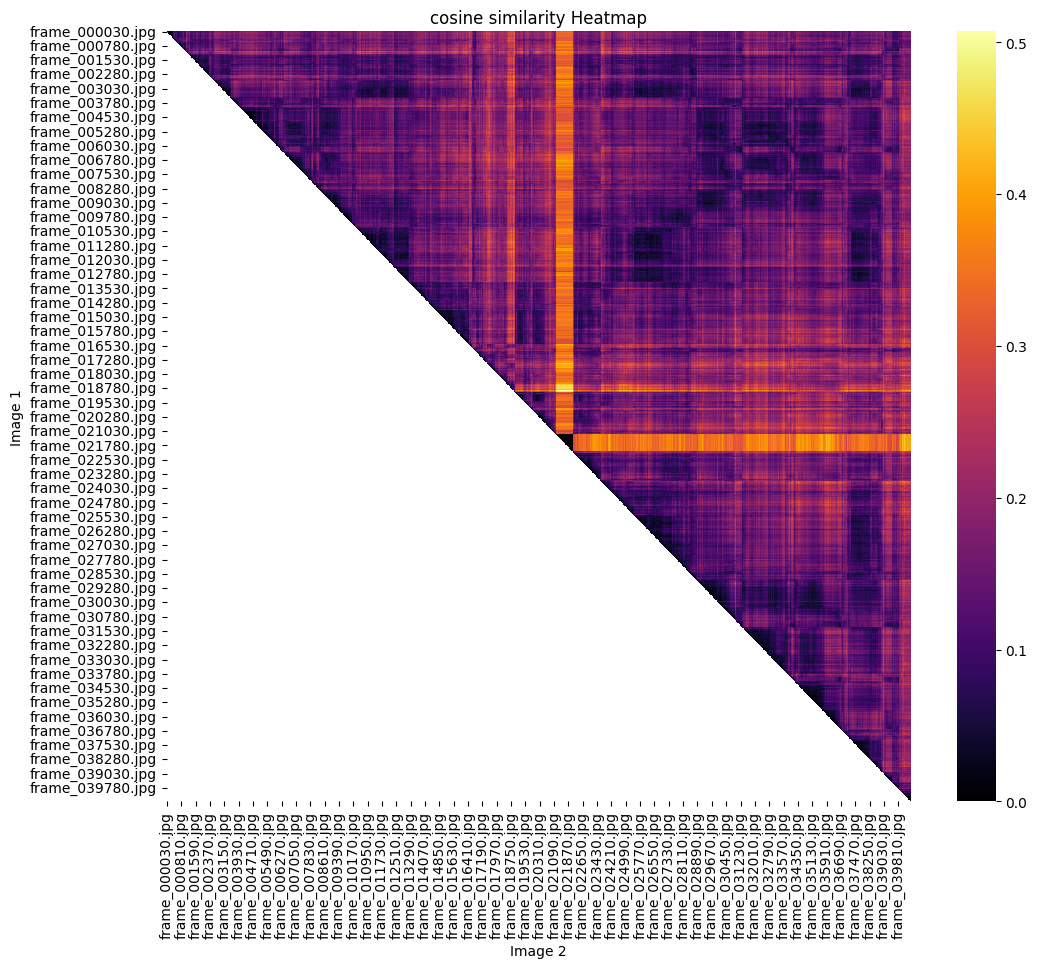

In [ ]:
# prompt: create a a model of heatmap with matplot

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cosine distance data
cosine_distances_df = pd.read_csv("/content/drive/My Drive/tcc/embeddingsCosine.csv")

# Create a pivot table for the heatmap
cosine_heatmap_data = cosine_distances_df.pivot(index='image1', columns='image2', values='distance')

# Create the heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(cosine_heatmap_data, cmap="inferno", annot=False)  # Use a suitable colormap
plt.title("cosine similarity Heatmap")
plt.xlabel("Image 2")
plt.ylabel("Image 1")
plt.show()

### Cosine Line

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('_mpl-gallery')

distance_csv = pd.read_csv("/drive/MyDrive/tcc/SBR/IFES/Distances_llava/rota/rota.csv")
et=40
print(distance_csv.head())
#distances_csv_path = pd.read_csv("/content/drive/My Drive/tcc/embeddingsCosine.csv")
#pivot_cosine = distances_csv_path.pivot(index='image1', columns='time', values='distance')
for range_frame in range(1,len(os.listdir("/content/drive/MyDrive/SBR/IFES/Frames/rota")),1):
  distance_df = select_frame_time(distance_csv, start_frame=range_frame-1, end_frame=range_frame, end_time=et)

  range_image = distance_df['image1'].iloc[0]
  range_distance = distance_df['distance']
  range_time = distance_df['image2']

  #print(range_time.iloc[-1])
  # plot
  fig, ax = plt.subplots(figsize=(10, 5))

  ax.plot(range_time, range_distance, linewidth=1.5)

  ax.set(xlim=(range_time.iloc[0], range_time.iloc[-1]), xticks=(range_time.iloc[0], range_time.iloc[-1]), title=range_image)

  plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/drive/MyDrive/tcc/SBR/IFES/Distances_llava/rota/rota.csv'

#Extrair Imagem do PDF (tempoario)

In [ ]:
%pip install PyMuPDF
from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 98.4 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
def extract_images_and_titles_from_pdf(pdf_path, output_folder):
    """
    Extracts images and attempts to find associated titles from a PDF file.

    Args:
        pdf_path (str): The path to the input PDF file.
        output_folder (str): The path to the folder where extracted images will be saved.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    try:
        doc = fitz.open(pdf_path)
    except fitz.FileDataError as e:
        print(f"Error opening PDF file: {e}")
        return

    for page_index in range(len(doc)):
        page = doc[page_index]
        image_list = page.get_images(full=True)
        text_blocks = page.get_text("blocks")

        for img_index, img in enumerate(image_list):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image_ext = base_image["ext"]

            image_filename = f"page_{page_index + 1}_img_{img_index + 1}.{image_ext}"
            image_path = os.path.join(output_folder, image_filename)

            with open(image_path, "wb") as image_file:
                image_file.write(image_bytes)

            # Attempt to find a title based on proximity
            image_bbox = page.get_image_bbox(img)
            title = "No title found"  # Default title

            # Manually create an expanded bounding box for the image
            # The Rect constructor takes (x0, y0, x1, y1)
            expanded_image_bbox = fitz.Rect(
                image_bbox.x0 - 20,  # expand left
                image_bbox.y0 - 20,  # expand up
                image_bbox.x1 + 20,  # expand right
                image_bbox.y1 + 20   # expand down
            )

            for tb in text_blocks:
                text_bbox = fitz.Rect(tb[:4])
                text_content = tb[4]

                # Check if text block is close to the image by checking intersection with the expanded box
                if text_bbox.intersects(expanded_image_bbox):
                    # Use the first nearby/intersecting text as the title
                    title = text_content.strip()
                    break

            print(f"Saved image: {image_filename}, Title: {title}")

    print(f"Finished extracting images and attempting to find titles. Saved to: {output_folder}")

In [ ]:
# Use the function with your paths
pdf_file_path = '/content/drive/MyDrive/tcc/keyframe_names.pdf'  # Replace with your PDF file path
output_directory = '/content/drive/MyDrive/tcc/keyframesTemp/'  # Replace with your desired output folder


extract_images_and_titles_from_pdf(pdf_file_path, output_directory)

Saved image: page_1_img_1.jpeg, Title: Description frame_001080.jpg: i see a image of a person standing in a doorway 
Time: 540.5s
Saved image: page_1_img_2.jpeg, Title: No title found
Saved image: page_1_img_3.jpeg, Title: No title found
Saved image: page_1_img_4.jpeg, Title: No title found
Saved image: page_1_img_5.jpeg, Title: No title found
Saved image: page_1_img_6.jpeg, Title: No title found
Saved image: page_1_img_7.jpeg, Title: No title found
Saved image: page_1_img_8.jpeg, Title: No title found
Saved image: page_1_img_9.jpeg, Title: No title found
Saved image: page_1_img_10.jpeg, Title: No title found
Saved image: page_1_img_11.jpeg, Title: No title found
Saved image: page_1_img_12.jpeg, Title: No title found
Saved image: page_1_img_13.jpeg, Title: No title found
Saved image: page_1_img_14.jpeg, Title: No title found
Saved image: page_1_img_15.jpeg, Title: No title found
Saved image: page_1_img_16.jpeg, Title: No title found
Saved image: page_1_img_17.jpeg, Title: No title fou

# llava-1.5-7b-hf


In [ ]:
!pip install --upgrade -q accelerate bitsandbytes
!pip install -q git+https://github.com/huggingface/transformers.git
# Depois de executar esta célula, vá em "Ambiente de execução" -> "Reiniciar ambiente de execução" no menu do Colab.

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)


model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, quantization_config=quantization_config, device_map="auto")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## llava Description

In [ ]:
def getMessage(path):
  message = [
      {
          "role": "user",
          "content": [
              {"type": "image", "image": f"{path}"},
              {"type": "text", "text": "Describe the image in more details"},
          ],
      }
  ]
  return message

def generate_description_llava(image_path, prompt="Describe the image"):
  keyframes_description = []
  for filename in sorted(set(os.listdir(image_path))):
      full_image = os.path.join(image_path, filename)
      message = getMessage(full_image)

      description = run_inference(processor, model, message)[0]

      #description = description.replace(".",".\n")

      keyframes_description.append(f"{description}")
      print(f"{filename}: {description}")
  return keyframes_description

In [ ]:

keyframes_folders_path = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/KeyFrames/"

frames_folder_path = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Frames/"
frames_folder = sorted(set(os.listdir(frames_folder_path)))

pdf_folder_path = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/llava_pdf/"
os.makedirs(pdf_folder_path, exist_ok=True)

for i,o in enumerate(sorted(os.listdir(keyframes_folders_path))):
  image_folder = frames_folder_path+frames_folder[i]+"/"

  pdf_path = f"{pdf_folder_path}{o}.pdf"
  full_keyframes_path = os.path.join(keyframes_folders_path, o)

  print(full_keyframes_path)

  description = generate_description_llava(full_keyframes_path)
  #def save_images_with_description_to_pdf(image_folder, output_pdf_path, key_frames, keyframes_description):
  save_images_with_description_to_pdf(image_folder, pdf_path, sorted(set(os.listdir(full_keyframes_path))), description)



/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/KeyFrames/2014-06-25-16-45-34_stereo_centre_02
frame_000160.jpg: The image features a large white truck driving down a street. The truck is positioned in the middle of the scene, and it appears to be a delivery truck. There are several people walking along the street, with some of them closer to the truck and others further away.

In addition to the truck, there are two cars visible in the scene, one on the left side and the other on the right side of the street. The presence of pedestrians and vehicles suggests a busy urban environment.
frame_000560.jpg: The image depicts a city street with a black car driving down the road. The car is positioned in the middle of the scene, and there are several other cars and a truck visible in the background. 

There are multiple traffic lights in the area, with one on the left side of the street, another on the right side, and a third one further down the road. A few pedestrians can b

## Embeddings

In [ ]:
import os

def extract_frames_folder(image_folder):
  images = [filename for filename in os.listdir(image_folder) if filename.endswith((".jpg", ".jpeg", ".png"))]
  images.sort()
  return images

image_folder = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Frames/2014-06-25-16-45-34_stereo_centre_02_frames/"

In [ ]:
def save_embedding_llava_csv(output_path, filename, image_folder_path):
  name = os.path.splitext(filename)[0]

  os.makedirs(output_path+"/"+name, exist_ok=True)
  output_csv_path = output_path + filename
  images = extract_frames_folder(image_folder_path)

  header = ['image_name'] + [f'embedding_{i}' for i in range(576)]  # Tamanho do embedding de 576 (lava)
  print(output_csv_path)
  # Abrindo o arquivo CSV em modo append (para adicionar dados no arquivo)
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  with open(output_csv_path, mode='w') as file:
      writer  = csv.writer(file)
      writer.writerow(header)  # Escreve o cabeçalho

      for imagename in images:
          print(imagename)
          image_path = os.path.join(image_folder, imagename)
          image = Image.open(image_path)

          inputs = processor(text=["<image>\nWhat’s shown in this image?"], images=image, return_tensors="pt", padding=True).to(device)
          outputs = model(**inputs)
          #image_embeddings = outputs.image_hidden_states.detach().cpu().numpy().tolist()  # Move para CPU antes de converter para numpy

          # Adiciona o nome da imagem e os embeddings à lista para escrever no CSV
          writer.writerow([imagename] + outputs.image_hidden_states.detach().cpu().numpy().tolist()) # Escreve a linha no CSV

  print("Done")

In [ ]:
%%time
output_csv_path = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Embeddings/Embeddings_LLaVa/"

frames_folder_path = "/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Frames/"

for i,o in enumerate(sorted(os.listdir(frames_folder_path))):
  dataset_name = o.split("_frames")[0]

  file_csv = f"{dataset_name}.csv"
  image_folder = frames_folder_path+o+"/"
  print(image_folder)
  break
  save_embedding_llava_csv(output_csv_path, file_csv, image_folder)

/content/drive/MyDrive/tcc/SBR/OxfordCarAutomatGIT-dataSetGIthub/Frames/2014-06-25-16-45-34_stereo_centre_02_frames/
CPU times: user 1.21 ms, sys: 0 ns, total: 1.21 ms
Wall time: 1.68 ms


# PipeLine LlaVa

## Model

In [ ]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)


model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, quantization_config=quantization_config, device_map="auto")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

## Functions

### Generic Functions

In [ ]:
 def is_folder_empty(folder_path):
  if not os.path.isdir(folder_path):
    print(f"Error: {folder_path} is not a valid directory.")
    return False
  return not os.listdir(folder_path)

### Extract Frames

In [ ]:
from decord import VideoReader
from decord import cpu, gpu

def extract_frames(video_path, frames_dir, overwrite=False, start=-1, end=-1, every=1):
    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible

    video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path
    video_name = os.path.splitext(video_filename)[0]

    assert os.path.exists(video_path)  # assert the video file exists

    # load the VideoReader
    vr = VideoReader(video_path, ctx=cpu(0))  # can set to cpu or gpu .. ctx=gpu(0)

    if start < 0:  # if start isn't specified lets assume 0
        start = 0
    if end < 0:  # if end isn't specified assume the end of the video
        end = len(vr)

    frames_list = list(range(start, end, every))
    saved_count = 0

    if every > 25 and len(frames_list) < 1000:  # this is faster for every > 25 frames and can fit in memory
        frames = vr.get_batch(frames_list).asnumpy()

        for index, frame in zip(frames_list, frames):  # lets loop through the frames until the end
            save_path = os.path.join(frames_dir, video_name, "frame_{:06d}.jpg".format(index))  # create the save path
            if not os.path.exists(save_path) or overwrite:  # if it doesn't exist or we want to overwrite anyways
                cv2.imwrite(save_path, cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # save the extracted image
                saved_count += 1  # increment our counter by one

    else:  # this is faster for every <25 and consumes small memory
        for index in range(start, end):  # lets loop through the frames until the end
            frame = vr[index]  # read an image from the capture

            if index % every == 0:  # if this is a frame we want to write out based on the 'every' argument
                save_path = os.path.join(frames_dir, video_name, "frame_{:06d}.jpg".format(index))  # create the save path
                if not os.path.exists(save_path) or overwrite:  # if it doesn't exist or we want to overwrite anyways
                    cv2.imwrite(save_path, cv2.cvtColor(frame.asnumpy(), cv2.COLOR_RGB2BGR))  # save the extracted image
                    saved_count += 1  # increment our counter by one

    return saved_count  # and return the count of the images we saved

def extract_frames_decord(video_path, frames_dir, overwrite=False, every=1):
    """
    Extracts the frames from a video
    :param video_path: path to the video
    :param frames_dir: directory to save the frames
    :param overwrite: overwrite frames if they exist?
    :param every: extract every this many frames
    :return: path to the directory where the frames were saved, or None if fails
    """

    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible

    print(video_path)
    print(frames_dir)

    video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path
    video_filename = os.path.basename(video_filename)
    video_name = os.path.splitext(video_filename)[0]

    # make directory to save frames, its a sub dir in the frames_dir with the video name
    os.makedirs(os.path.join(frames_dir, video_name), exist_ok=True)

    print("Extracting frames from {}".format(video_filename))

    count = extract_frames(video_path, frames_dir, every=every)  # let's now extract the frames
    print(f"Saved {count} frames.")

    return os.path.join(frames_dir, video_name)  # when done return the directory


"""def extract_frames(video_path, output_path, range_frame):
    print("==Extraindo Frames")
    # Create the output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if video.isOpened() == False:
        print("Error opening video file")
        return

    frame_count = 0
    while video.isOpened():
        frame_count += 1
        # Read a frame from the video
        success, frame = video.read()

        # Break the loop if no frame is read
        if not success:
            break

        #save 10fps
        if(not (frame_count % range_frame)):
          # Save the frame as an image
          frame_path = os.path.join(output_path, f"frame_{frame_count:06d}.jpg")
          cv2.imwrite(frame_path, frame)
          #print(f"Extracted frame {frame_count}")

    # Release the video object
    video.release()

    print(f"Extracted {frame_count} frames to {output_path}")"""

def get_video_fps(video_path):
  cap = cv2.VideoCapture(video_path)
  if not cap.isOpened():
    print(f"Error: Could not open video file {video_path}")
    return None
  fps = cap.get(cv2.CAP_PROP_FPS)
  cap.release()
  return fps

### Embeddings

In [ ]:
def extract_frames_folder(image_folder):
  images = [filename for filename in os.listdir(image_folder) if filename.endswith((".jpg", ".jpeg", ".png"))]
  images.sort()
  return images

def save_embedding_llava_csv(output_path, filename, image_folder_path):
  print("==Salvando Embeddings")
  name = os.path.splitext(filename)[0]

  os.makedirs(output_path+"/"+name, exist_ok=True)
  output_csv_path = output_path+"/"+name+"/"+filename

  images = extract_frames_folder(image_folder_path)

  header = ['image_name'] + [f'embedding_{i}' for i in range(4096)]  # Tamanho do embedding de 2359296 (lava)
  print(output_csv_path)
  # Abrindo o arquivo CSV em modo append (para adicionar dados no arquivo)
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  with open(output_csv_path, mode='w') as file:
      writer  = csv.writer(file)
      writer.writerow(header)  # Escreve o cabeçalho
      print("Carregando Embeddings dos Frames:")
      for imagename in images:
          image_path = os.path.join(image_folder_path, imagename)
          image = Image.open(image_path)

          inputs = processor(text=["<image>\nWhat’s shown in this image?"], images=image, return_tensors="pt", padding=True).to(device)
          outputs = model(**inputs)
          #image_embeddings = outputs.image_hidden_states.detach().cpu().numpy().tolist()  # Move para CPU antes de converter para numpy

          # Adiciona o nome da imagem e os embeddings à lista para escrever no CSV
          writer.writerow([imagename] + outputs.image_hidden_states[0].detach().cpu().numpy().flatten().tolist()) # Escreve a linha no CSV

  print("Done")

### Distance between ebeddings

In [ ]:
def cosine_distance(embedding1, embedding2):
  """Calculates the cosine distance between two embedding vectors."""
  return cosine(embedding1, embedding2)

## Calculate consine distance and save in a file
def calculate_and_save_distances(embeddings_directory, output_directory):
    print("==Distancia entre os embeddings")
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)
    print("Embeddings Diretorio: "+embeddings_directory)

    # Iterate through all files in the embeddings directory
    for filename in os.listdir(embeddings_directory):
        # Check if the file is a CSV file and ends with '_embeddings.csv'
        if filename.endswith(".csv"):
            print(filename)
            embeddings_csv_path = os.path.join(embeddings_directory, filename)

            try:
                # Load embeddings from the current CSV file
                print("Carregando arquivo....")
                embeddings_df = pd.read_csv(embeddings_csv_path)
                print("Arquivo Carregado!")

                # Extract the base name for the output cosine distance CSV
                # e.g., 'video1_embeddings.csv' -> 'video1_cosineDistances.csv'
                base_name = filename.replace(".csv", "")

                os.makedirs(output_directory+"/"+base_name, exist_ok=True)
                output_directory = output_directory+"/"+base_name

                distances_csv_path = os.path.join(output_directory, f"{base_name}.csv")

                print(f"Calculating cosine distances for {filename}...")

                # Prepare a list to store distance data
                distance_data = []

                # Calculate distance between all pairs of images in the DataFrame
                # Iterate through rows using index for easier access to image names
                for i in range(len(embeddings_df)):
                    # Extract image name and embedding for the first image
                    image_name_i = embeddings_df.iloc[i, 0]
                    image_i = np.array(embeddings_df.iloc[i, 1:])  # Extract embeddings, skip image name

                    # Iterate through the remaining rows (including i) to get pairs
                    for j in range(i, len(embeddings_df)):
                        # Extract image name and embedding for the second image
                        image_name_j = embeddings_df.iloc[j, 0]
                        image_j = np.array(embeddings_df.iloc[j, 1:])

                        # Calculate the cosine distance
                        distance = cosine_distance(image_i, image_j)

                        # Append the image pair and distance to the data list
                        distance_data.append([image_name_i, image_name_j, distance])
                        #print(distance)
                # Save distances to a new CSV file in the output directory
                with open(distances_csv_path, 'w', newline='') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow(['image1', 'image2', 'distance'])  # Write header row
                    writer.writerows(distance_data) # Write all the collected data rows

                print(f"Cosine distances for {filename} saved to {distances_csv_path}")

            except Exception as e:
                print(f"Error processing {filename}: {e}")
                continue # Continue with the next file even if one fails

### KeyFrames

In [ ]:
def copyImage(diretorio_origem, diretorio_destino, nome_arquivo_imagem):
  # Define o caminho completo para a imagem de origem
  caminho_imagem_origem = os.path.join(diretorio_origem, nome_arquivo_imagem)

  # Cria o diretório de destino se ele não existir
  os.makedirs(diretorio_destino, exist_ok=True)

  # Define o caminho completo para onde a cópia será salva
  caminho_imagem_destino = os.path.join(diretorio_destino, nome_arquivo_imagem)

  # Verifica se o arquivo de imagem de origem existe
  if os.path.exists(caminho_imagem_origem):
      try:
          # Copia o arquivo
          shutil.copy2(caminho_imagem_origem, caminho_imagem_destino)
          print(f"Imagem copiada com sucesso: {nome_arquivo_imagem} para {diretorio_destino}")
      except Exception as e:
          print(f"Erro ao copiar a imagem: {e}")
  else:
      print(f"Erro: A imagem de origem não foi encontrada em {caminho_imagem_origem}")

#cria uma pasta
def create_folder_with_csvPath(path,filename):
  output_directory_path = path+"/"+filename+"/"
  os.makedirs(output_directory_path, exist_ok=True)
  return output_directory_path

def select_key_frames(csv_path, extracted_frame_path, distance_min):
  distance_csv = pd.read_csv(csv_path)
  key_frames = []
  print(distance_min)
  for range_frame in range(10,len(os.listdir(extracted_frame_path)),10):
    #extrai uma relacao frame x tempo
    #frame = linha e o tempo = colunas
    print()
    distance_df = select_frame_time(distance_csv, start_frame=range_frame-10, end_frame=range_frame, end_time=20)

    # Soma todas
    time_sums = distance_df.groupby('image2')['distance'].sum()#.reset_index()
    # Conta a quantidade de valores não null por coluna
    n_unique_times = distance_df.groupby('image2')['distance'].nunique()

    #Busca o tempo com o embedding mais distante
    max_val = time_sums.max()
    # Calcula todas as médias de uma vez (vetorizado)
    avar_series = time_sums / n_unique_times
    # Encontra o primeiro índice que satisfaz a condição
    mask = avar_series > distance_min

    if mask.any():
        first_index = mask.idxmax()
        #print(first_index)
        #file_kf = f"frame_{timetoframe60fps(int(first_index)):06d}.jpg"
        key_frames.append(first_index)
        range_frame = extract_number_from_filename(first_index)/10

  return key_frames

def select_keyframes(csv_path, frames_path, keyframes_path, dist_min=0.15):
  print("==Selecionando KeyFrames")
  for i in sorted(os.listdir(csv_path)):
    full_csv_path = os.path.join(csv_path, i)

    filename, csv = os.path.splitext(os.path.basename(i))
    #filename = filename_without_extension.replace("_cosineDistances","")

    # Constrói o caminho esperado para a pasta de frames correspondente
    #full_frames_path = os.path.join(frames_path, filename)

    output_path = create_folder_with_csvPath(keyframes_path,filename)
    print("Path criado:"+output_path)
    print(full_csv_path)
    print(frames_path)
    return select_key_frames(full_csv_path, frames_path, dist_min)

def save_keyframes(frames_path,keyframes_path,keyframes):
  print("==Salvando KeyFrames")
  #To save keyframess
  for k in keyframes:
     copyImage(frames_path, keyframes_path, k)


### Description

In [ ]:
def getMessage(path,prompt):
  message = [
      {
          "role": "user",
          "content": [
              {"type": "image", "image": f"{path}"},
              {"type": "text", "text": f"{prompt}"},
          ],
      }
  ]
  return message

def generate_description_llava(image_path, prompt="Describe the image"):
  print("==Gerando Descricao")
  print("Prompt: "+prompt)
  keyframes_description = []
  for filename in sorted(set(os.listdir(image_path))):
      full_image = os.path.join(image_path, filename)
      message = getMessage(full_image,prompt)

      description = run_inference(processor, model, message)[0]

      #description = description.replace(".",".\n")

      keyframes_description.append(f"{description}")
      print(f"{filename}: {description}")
  return keyframes_description


### Save Description and image to PDF




In [ ]:
#extrai o valor do frame no nome do arquivo
def extract_number_from_filename(filename):
  try:
    # Encontra a posição do underscore e do ponto
    underscore_index = filename.index('_')
    dot_index = filename.index('.')

    # Extrai a parte numérica entre o underscore e o ponto
    number_str = filename[underscore_index + 1:dot_index]

    # Converte a string numérica para um inteiro
    number = int(number_str)

    return number
  except ValueError:
    # Retorna None se não conseguir converter para inteiro
    return None

def save_images_with_description_to_pdf(image_folder, output_pdf_path, key_frames, keyframes_description, fps):
    print("==Salvando Descricao e Imagens em PDF")
    pdf = FPDF()
    keyframes = [f for f in os.listdir(key_frames) if f.endswith((".jpg", ".jpeg", ".png"))]
    keyframes.sort()  # Sort to ensure consistent order
    pdf.set_font("Arial", size=12)
    pdf.set_auto_page_break(auto=True, margin=15)

    #percorre os keyframes
    #i eh o indice
    #image_file eh o nome do arquivo
    for i, image_file in enumerate(sorted(set(keyframes))):
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path)
        #cria uma pagina no pdf
        pdf.add_page()
        #Adiciono a imagem na pagina
        pdf.image(image_path, x=5, y=100, w=300)  # Adjust x, y, and w as needed
        #Adiciona a descricao na pagina
        pdf.multi_cell(0, 10, txt=f"Description {image_file}: {keyframes_description[i]} \nTime: {extract_number_from_filename(image_file)/fps:.2f}s", border=0, align="L")  # Adjust y as needed

    pdf.output(output_pdf_path)


### Save description to file

In [ ]:
import csv
import numpy as np
from scipy.spatial.distance import cosine
import os
import pandas as pd
import shutil
from fpdf import FPDF
import cv2


def save_descriptions_to_files(descriptions, output_directory):
  print("==Salvando Descricoes")
  # Ensure the output directory exists
  os.makedirs(output_directory, exist_ok=True)

  for i, description in enumerate(descriptions):
    # Create a unique filename for each description
    filename = f"description_{i+1}.txt"
    file_path = os.path.join(output_directory, filename)

    # Save the description to the text file
    try:
      with open(file_path, "w", encoding="utf-8") as f:
        f.write(description)
      print(f"Description {i+1} saved to {file_path}")
    except Exception as e:
      print(f"Error saving description {i+1} to {file_path}: {e}")


## Run

In [ ]:
%%time
def pipeline_llava(video_path):
  #Path to video
  source_path = os.path.dirname(video_path)
  filename = os.path.basename(video_path)
  #filename without file format
  video_name = os.path.splitext(filename)[0]
  fps = get_video_fps(video_path)

  #Cria a pasta de FRAMES se nao existir
  os.makedirs(source_path+"/Frames", exist_ok=True)
  #Cria a pasta de KEYFRAMES se nao existir
  os.makedirs(source_path+"/KeyFrames_llava", exist_ok=True)
  #Cria a pasta de EMBEDDINGS se nao existir
  os.makedirs(source_path+"/Embeddings_llava", exist_ok=True)
  #Cria a pasta de DESCRIPTIONS se nao existir
  os.makedirs(source_path+"/Descriptions_llava/"+video_name, exist_ok=True)
  #Cria a pasta de PDF se nao existir
  os.makedirs(source_path+"/pdf_llava/"+video_name, exist_ok=True)
  #Cria a pasta DISTANCE se nao existir
  os.makedirs(source_path+"/Distances_llava", exist_ok=True)

  #variables
  frames_dir = source_path+"/Frames/"
  frames_path = source_path+"/Frames/"+video_name
  embeddings_path = source_path+"/Embeddings_llava"
  embeddings_distance_path = source_path+"/Distances_llava"
  keyframes_path = source_path+"/KeyFrames_llava"
  output_pdf_path = source_path+"/pdf_llava/"+video_name+"/"+video_name+".pdf"
  descriptions_path = source_path+"/Descriptions_llava/"+video_name

  #Extract the frames video
  extract_frames_decord(video_path=video_path, frames_dir=frames_dir, overwrite=False, every=10) #extract 10% of the frames

  #Create a file .csv and save the embeddings from frame
  save_embedding_llava_csv(embeddings_path, video_name+".csv", frames_path)

  #get the cosine distance and save in file .csv
  calculate_and_save_distances(embeddings_path+"/"+video_name, embeddings_distance_path)

  #Select KeyFrames
  keyframes = select_keyframes(embeddings_distance_path+"/"+video_name, frames_path, keyframes_path, dist_min=0.2)

  #salva os keyframess
  save_keyframes(frames_path,keyframes_path+"/"+video_name,keyframes)

  #LlaVa gera um descricao para cada keyframe
  #generate_description_llava(image_path, prompt="Describe the image"):
  description = generate_description_llava(keyframes_path+"/"+video_name,
                                           #prompt="This is a log from an autonomous vehicle indoor in a university. describe the main elements using short, clear and  continuous phrases.")
                                           prompt="This image is a log of an autonomous car on a public street. Give a brief overview of the key detected elements and your directions using short, clear and continuous phrases.")

  #Sava a descricao e os keyframes em um pdf
  #def save_images_with_description_to_pdf(image_folder, output_pdf_path, key_frames, keyframes_description, fps):
  save_images_with_description_to_pdf(frames_path, output_pdf_path, keyframes_path+"/"+video_name, description, fps)

  #Salva a descricao do
  #def save_descriptions_to_files(descriptions, output_directory):
  save_descriptions_to_files(description,descriptions_path)

  return True

#video_path = "/content/drive/MyDrive/tcc/tcc/filmagemOsorim 2024-11-26 16-43-57.mp4"
video_directory = "/content/drive/MyDrive/SBR/dataSet/videos-20250525T005601Z-1-003/videos"
#pipeline_llava(video_path)

video_files = [f for f in os.listdir(video_directory) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
print(sorted(video_files))
for filename in sorted(video_files):
  video_path = os.path.join(video_directory, filename)
  #print("Video: "+video_path)
  pipeline_llava(video_path)

print("Done!")

['2015-02-03-19-43-11_stereo_centre_04.mp4']
/content/drive/MyDrive/SBR/dataSet/videos-20250525T005601Z-1-003/videos/2015-02-03-19-43-11_stereo_centre_04.mp4
/content/drive/MyDrive/SBR/dataSet/videos-20250525T005601Z-1-003/videos/Frames
Extracting frames from 2015-02-03-19-43-11_stereo_centre_04.mp4
Saved 600 frames.
==Salvando Embeddings
/content/drive/MyDrive/SBR/dataSet/videos-20250525T005601Z-1-003/videos/Embeddings_llava/2015-02-03-19-43-11_stereo_centre_04/2015-02-03-19-43-11_stereo_centre_04.csv
Carregando Embeddings dos Frames:
Done
==Distancia entre os embeddings
Embeddings Diretorio: /content/drive/MyDrive/SBR/dataSet/videos-20250525T005601Z-1-003/videos/Embeddings_llava/2015-02-03-19-43-11_stereo_centre_04
2015-02-03-19-43-11_stereo_centre_04.csv
Carregando arquivo....
Arquivo Carregado!
Calculating cosine distances for 2015-02-03-19-43-11_stereo_centre_04.csv...
Cosine distances for 2015-02-03-19-43-11_stereo_centre_04.csv saved to /content/drive/MyDrive/SBR/dataSet/videos-